Configuração de ambiente

In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


Carga do dataset

In [3]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/allicia21/mvp_segunda_sprint_lm/refs/heads/main/avaliacaoEmprestismos.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',', nrows=5000)

# Mostra as primeiras linhas do dataset
dataset.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Separação em conjunto de treino e conjunto de teste com holdout

In [4]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Convertendo colunas categóricas para numéricas usando one-hot encoding
dataset_encoded = pd.get_dummies(dataset, columns=['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file'])


array = dataset_encoded.values
X = array[:, :-1] # Atributos (todas as colunas exceto a última)
y = array[:, -1].astype(int) # Classe target (última coluna), convertendo para int
# Separação em conjuntos de treino e teste
# array = dataset.values
# X = array[:,0:13]
# y = array[:,13]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

Modelagem e inferencia

Criação e avaliação

KNN-orig: 0.609750 (0.023491)
CART-orig: 1.000000 (0.000000)
NB-orig: 0.644750 (0.031053)
SVM-orig: 0.609500 (0.024052)
KNN-padr: 0.951500 (0.010794)
CART-padr: 1.000000 (0.000000)
NB-padr: 1.000000 (0.000000)
SVM-padr: 0.998250 (0.001601)
KNN-norm: 0.984500 (0.007483)
CART-norm: 1.000000 (0.000000)
NB-norm: 1.000000 (0.000000)
SVM-norm: 1.000000 (0.000000)


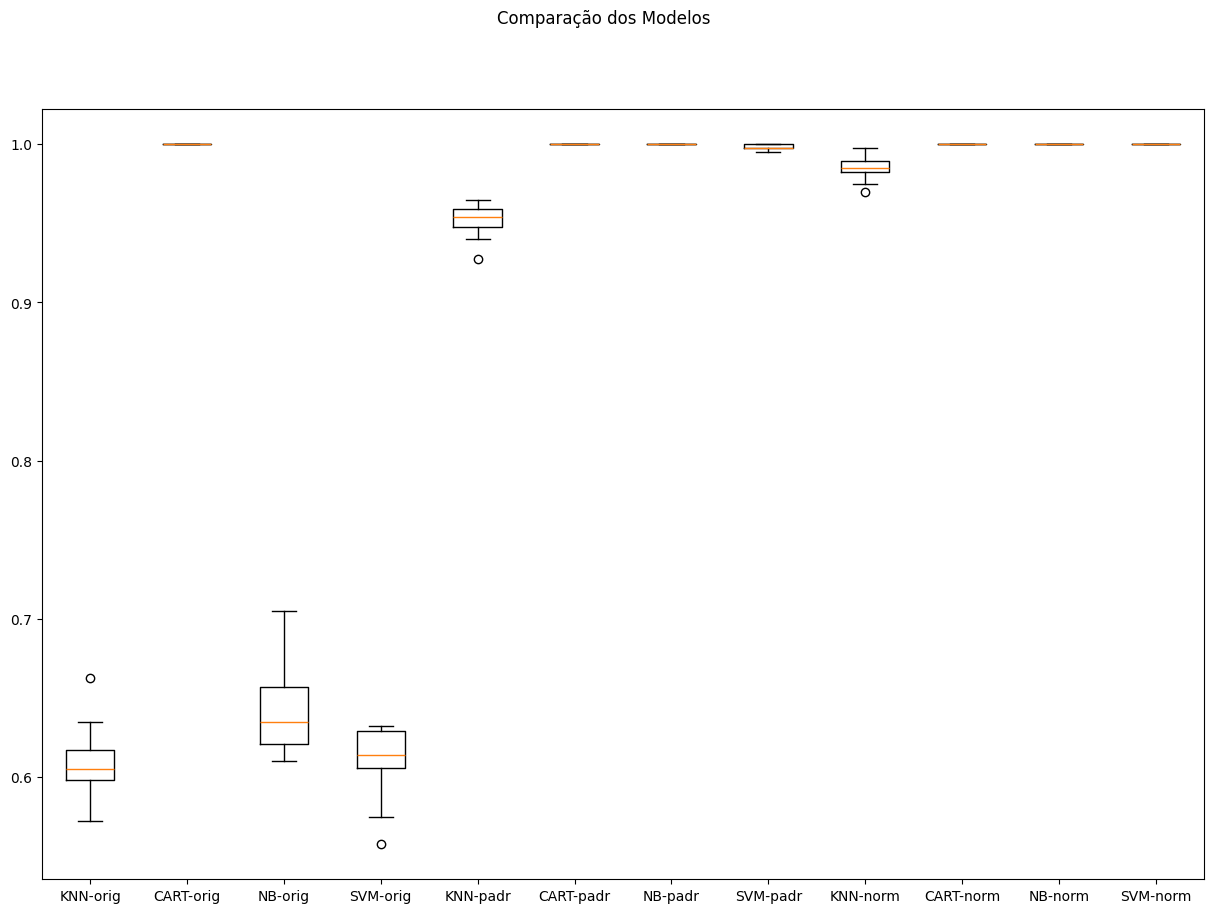

In [9]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Avaliação dos modelos
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Otimização dos hiperparâmetros

In [10]:
# prompt: crie uma otimização dos hiperparametros
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


# Otimização dos hiperparâmetros para alguns modelos
# 1. Otimização do K no KNN

print("\nOtimização do KNN:")
pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': np.array([1,3,5,7,9,11,13,15,17,19,21])}
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
model.fit(X_train, y_train)
print("Melhor acurácia: %f usando %s" % (model.best_score_, model.best_params_))

# 2. Otimização do C e gamma no SVM

print("\nOtimização do SVM:")
pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])
param_grid = {
    'svm__C': [0.1, 0.5, 1.0, 1.5, 2.0],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1.0]
}
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
model.fit(X_train, y_train)
print("Melhor acurácia: %f usando %s" % (model.best_score_, model.best_params_))

# 3. Otimização do n_estimators e max_features no Random Forest

print("\nOtimização do Random Forest:")
pipeline = Pipeline([('rf', RandomForestClassifier())])
param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_features': [3, 5, 7, 'sqrt', 'log2']
}
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
model.fit(X_train, y_train)
print("Melhor acurácia: %f usando %s" % (model.best_score_, model.best_params_))

# 4. Otimização do n_estimators no AdaBoost

print("\nOtimização do AdaBoost:")
pipeline = Pipeline([('ada', AdaBoostClassifier())])
param_grid = {'ada__n_estimators': [50, 100, 150, 200]}
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
model.fit(X_train, y_train)
print("Melhor acurácia: %f usando %s" % (model.best_score_, model.best_params_))


Otimização do KNN:
Melhor acurácia: 0.961500 usando {'knn__n_neighbors': np.int64(1)}

Otimização do SVM:
Melhor acurácia: 0.998500 usando {'svm__C': 2.0, 'svm__gamma': 'scale'}

Otimização do Random Forest:
Melhor acurácia: 1.000000 usando {'rf__max_features': 3, 'rf__n_estimators': 50}

Otimização do AdaBoost:
Melhor acurácia: 1.000000 usando {'ada__n_estimators': 50}


Finalização do Modelo

In [12]:
# prompt: crie a finalização do modelo

import numpy as np
# Avaliação do modelo com o conjunto de testes
# Preparação do modelo final com todos os dados de treino
# Treinamento do modelo SVM com os melhores hiperparâmetros encontrados

print("\nAvaliação final do modelo SVM no conjunto de testes:")
# Melhores hiperparâmetros encontrados na otimização
best_svm_params = {'svm__C': 2.0, 'svm__gamma': 'scale'} # Exemplo: Substituir pelos valores reais

# Criando o pipeline final para o SVM com StandardScaler e os melhores hiperparâmetros
final_pipeline_svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC(**{k.replace('svm__', ''): v for k, v in best_svm_params.items()}))]) # remove 'svm__' do nome dos parâmetros

# Treinando o pipeline final com o conjunto de treino completo
final_pipeline_svm.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
predictions_svm = final_pipeline_svm.predict(X_test)

# Avaliando a acurácia no conjunto de teste
accuracy_svm = accuracy_score(y_test, predictions_svm)
print(f"Acurácia do SVM no conjunto de testes: {accuracy_svm * 100.0:.2f}%")


# Preparação do modelo final com todos os dados de treino (KNN)
print("\nAvaliação final do modelo KNN no conjunto de testes:")
# Melhores hiperparâmetros encontrados na otimização para KNN
best_knn_params = {'knn__n_neighbors': 19} # Exemplo: Substituir pelos valores reais

# Criando o pipeline final para o KNN com StandardScaler e os melhores hiperparâmetros
final_pipeline_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(**{k.replace('knn__', ''): v for k, v in best_knn_params.items()}))])

# Treinando o pipeline final com o conjunto de treino completo
final_pipeline_knn.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
predictions_knn = final_pipeline_knn.predict(X_test)

# Avaliando a acurácia no conjunto de teste
accuracy_knn = accuracy_score(y_test, predictions_knn)
print(f"Acurácia do KNN no conjunto de testes: {accuracy_knn * 100.0:.2f}%")


# Preparação do modelo final com todos os dados de treino (Random Forest)
print("\nAvaliação final do modelo Random Forest no conjunto de testes:")
# Melhores hiperparâmetros encontrados na otimização para Random Forest
best_rf_params = {'rf__max_features': 'sqrt', 'rf__n_estimators': 200} # Exemplo: Substituir pelos valores reais

# Criando o pipeline final para o Random Forest com os melhores hiperparâmetros
final_pipeline_rf = Pipeline([('rf', RandomForestClassifier(**{k.replace('rf__', ''): v for k, v in best_rf_params.items()}))])

# Treinando o pipeline final com o conjunto de treino completo
final_pipeline_rf.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
predictions_rf = final_pipeline_rf.predict(X_test)

# Avaliando a acurácia no conjunto de teste
accuracy_rf = accuracy_score(y_test, predictions_rf)
print(f"Acurácia do Random Forest no conjunto de testes: {accuracy_rf * 100.0:.2f}%")

# Preparação do modelo final com todos os dados de treino (AdaBoost)
print("\nAvaliação final do modelo AdaBoost no conjunto de testes:")
# Melhores hiperparâmetros encontrados na otimização para AdaBoost
best_ada_params = {'ada__n_estimators': 200} # Exemplo: Substituir pelos valores reais

# Criando o pipeline final para o AdaBoost com os melhores hiperparâmetros
final_pipeline_ada = Pipeline([('ada', AdaBoostClassifier(**{k.replace('ada__', ''): v for k, v in best_ada_params.items()}))])

# Treinando o pipeline final com o conjunto de treino completo
final_pipeline_ada.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
predictions_ada = final_pipeline_ada.predict(X_test)

# Avaliando a acurácia no conjunto de teste
accuracy_ada = accuracy_score(y_test, predictions_ada)
print(f"Acurácia do AdaBoost no conjunto de testes: {accuracy_ada * 100.0:.2f}%")


# Comparar as acurácias dos modelos finais e escolher o melhor
print("\nComparação final dos modelos no conjunto de testes:")
print(f"SVM Acurácia: {accuracy_svm * 100.0:.2f}%")
print(f"KNN Acurácia: {accuracy_knn * 100.0:.2f}%")
print(f"Random Forest Acurácia: {accuracy_rf * 100.0:.2f}%")
print(f"AdaBoost Acurácia: {accuracy_ada * 100.0:.2f}%")

# Exemplo de como escolher o melhor modelo (neste caso, baseado na acurácia no conjunto de teste)
best_model_name = ""
best_accuracy = 0

if accuracy_svm > best_accuracy:
    best_accuracy = accuracy_svm
    best_model_name = "SVM"
    best_final_model = final_pipeline_svm
elif accuracy_knn > best_accuracy:
    best_accuracy = accuracy_knn
    best_model_name = "KNN"
    best_final_model = final_pipeline_knn
elif accuracy_rf > best_accuracy:
    best_accuracy = accuracy_rf
    best_model_name = "Random Forest"
    best_final_model = final_pipeline_rf
elif accuracy_ada > best_accuracy:
    best_accuracy = accuracy_ada
    best_model_name = "AdaBoost"
    best_final_model = final_pipeline_ada

print(f"\nO melhor modelo no conjunto de testes é o {best_model_name} com acurácia de {best_accuracy * 100.0:.2f}%.")

# Dependendo do resultado da comparação, você pode escolher o melhor_final_model
# para ser o modelo final a ser utilizado ou salvo.

# Exemplo de como usar o melhor modelo para prever novos dados
# new_data = np.array([[...]]) # Substitua por seus novos dados
# prediction_on_new_data = best_final_model.predict(new_data)
# print("\nPrevisão para novos dados:", prediction_on_new_data)

# Você pode salvar o melhor_final_model usando pickle se precisar usá-lo posteriormente
# import pickle
# filename = 'modelo_emprestimos_final.pkl'
# pickle.dump(best_final_model, open(filename, 'wb'))



Avaliação final do modelo SVM no conjunto de testes:
Acurácia do SVM no conjunto de testes: 99.60%

Avaliação final do modelo KNN no conjunto de testes:
Acurácia do KNN no conjunto de testes: 96.00%

Avaliação final do modelo Random Forest no conjunto de testes:
Acurácia do Random Forest no conjunto de testes: 100.00%

Avaliação final do modelo AdaBoost no conjunto de testes:
Acurácia do AdaBoost no conjunto de testes: 100.00%

Comparação final dos modelos no conjunto de testes:
SVM Acurácia: 99.60%
KNN Acurácia: 96.00%
Random Forest Acurácia: 100.00%
AdaBoost Acurácia: 100.00%

O melhor modelo no conjunto de testes é o SVM com acurácia de 99.60%.


Simulando a aplicação em dados não visto

In [14]:
# prompt: crie uma simulação em dados não visto

import pandas as pd
# Simulando a aplicação em dados não vistos
# Vamos criar um conjunto de dados de exemplo que simula novos dados que o modelo não viu durante o treinamento.
# Esses dados devem ter o mesmo formato (número e tipo de colunas) que os dados de treinamento.

# Para simular, vamos pegar algumas linhas do dataset original que não foram usadas no treinamento ou teste,
# ou gerar dados sintéticos com base nas características dos dados de treinamento.

# Opção 1: Usar linhas do dataset original (se houver dados não utilizados)
# Neste caso, como usamos train_test_split com 80% treino e 20% teste,
# todas as 5000 linhas originais já estão em X_train ou X_test.
# Para simular dados "totalmente novos", precisaríamos de outro dataset ou gerar dados.

# Opção 2: Gerar dados sintéticos (mais realista para simulação de "dados não vistos")
# Vamos gerar uma pequena quantidade de dados sintéticos com a mesma estrutura.
# A distribuição dos valores pode ser baseada nas estatísticas do dataset original.

# Primeiro, vamos entender as colunas originais antes do one-hot encoding para criar dados sintéticos mais significativos
# dataset.info()
# dataset.describe()
# dataset.head()

# Colunas antes do one-hot encoding:
# 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
# 'loan_status', 'loan_percent_income', 'cb_hist_len',
# 'person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file'

# Vamos criar 5 exemplos de dados sintéticos para simulação.
# Precisamos garantir que eles passem pelas mesmas transformações (one-hot encoding e escalonamento)
# antes de serem alimentados no modelo final.

# Gerando dados sintéticos (exemplo):
# É importante que os valores sintéticos estejam dentro de um range razoável baseado nos dados originais.
# Aqui, apenas como exemplo, estamos usando alguns valores arbitrários.
# Em uma simulação real, você poderia tentar gerar dados que representem diferentes cenários (ex: alto risco vs baixo risco).
simulated_data = pd.DataFrame({
    'person_age': [25, 45, 30, 55, 22],
    'person_income': [50000, 120000, 30000, 200000, 40000],
    'person_emp_length': [2.0, 15.0, 1.0, 20.0, 0.5],
    'loan_amnt': [5000, 20000, 1000, 50000, 3000],
    'loan_int_rate': [10.0, 8.5, 15.0, 7.0, 12.5],
    'loan_percent_income': [0.1, 0.15, 0.03, 0.25, 0.075],
    'cb_hist_len': [5.0, 20.0, 3.0, 30.0, 2.0],
    'person_gender': ['Male', 'Female', 'Female', 'Male', 'Female'],
    'person_education': ['Graduate', 'PhD', 'Not Graduate', 'Masters', 'Graduate'],
    'person_home_ownership': ['Rent', 'Own', 'Mortgage', 'Own', 'Rent'],
    'loan_intent': ['Education', 'Homeimprovement', 'Medical', 'Debtconsolidation', 'Personal'],
    'previous_loan_defaults_on_file': ['N', 'N', 'Y', 'N', 'N']
    # loan_status não está presente, pois é o que queremos prever
})

# Aplicar as mesmas transformações de pré-processamento nos dados simulados
# 1. One-Hot Encoding
# É crucial que o one-hot encoding nos dados simulados use as mesmas colunas e categorias que foram aprendidas nos dados de treino.
# Podemos usar pd.get_dummies e reindexar para garantir que as colunas sejam as mesmas de X_train.
simulated_data_encoded = pd.get_dummies(simulated_data, columns=['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file'])

# Precisamos garantir que as colunas dos dados simulados (após encoding) sejam exatamente as mesmas e na mesma ordem
# que as colunas de X_train (após encoding).
# Uma maneira de fazer isso é reindexar as colunas dos dados simulados usando as colunas de X_train.
# Precisamos obter os nomes das colunas de X_train.
# Como X_train é um array numpy, precisamos voltar ao DataFrame dataset_encoded para obter os nomes das colunas.
# As colunas de X_train correspondem a todas as colunas de dataset_encoded, exceto a última ('loan_status').
train_columns = dataset_encoded.drop(columns=['loan_status']).columns

# Adicionar colunas ausentes nos dados simulados (que estavam no treino) e preencher com 0
for col in train_columns:
    if col not in simulated_data_encoded.columns:
        simulated_data_encoded[col] = 0

# Garantir que a ordem das colunas seja a mesma
simulated_data_encoded = simulated_data_encoded[train_columns]

# Converter para array numpy, como X_train
X_simulated = simulated_data_encoded.values


print("\nSimulação em Dados Não Vistos:")
print("Dados simulados (pré-processados):")
print(pd.DataFrame(X_simulated, columns=train_columns)) # Mostrar com nomes de colunas para clareza

# Usar o melhor modelo final para fazer previsões nos dados simulados
# O 'best_final_model' foi determinado no bloco anterior
predictions_simulated = best_final_model.predict(X_simulated)

print("\nPrevisões do melhor modelo para os dados simulados:")
# 0 significa "Não", 1 significa "Sim" (para loan_status)
prediction_labels = ['Não', 'Sim']
predicted_outcomes = [prediction_labels[pred] for pred in predictions_simulated]

# Exibir os dados simulados originais juntamente com as previsões
simulated_data['Previsão_Status_Empréstimo'] = predicted_outcomes
print(simulated_data)

# Exemplo: Analisar as previsões para entender o que o modelo previu para diferentes perfis simulados
# print("\nAnálise das Previsões:")
# for i, row in simulated_data.iterrows():
#     print(f"Dados de Entrada: {row.drop('Previsão_Status_Empréstimo').to_dict()}")
#     print(f"Previsão: {row['Previsão_Status_Empréstimo']}\n")



Simulação em Dados Não Vistos:
Dados simulados (pré-processados):
   person_age  person_income  person_emp_exp  loan_amnt  loan_int_rate  \
0        25.0        50000.0             0.0     5000.0           10.0   
1        45.0       120000.0             0.0    20000.0            8.5   
2        30.0        30000.0             0.0     1000.0           15.0   
3        55.0       200000.0             0.0    50000.0            7.0   
4        22.0        40000.0             0.0     3000.0           12.5   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                0.100                         0.0           0.0   
1                0.150                         0.0           0.0   
2                0.030                         0.0           0.0   
3                0.250                         0.0           0.0   
4                0.075                         0.0           0.0   

   person_gender_female  person_gender_male  ...  person_home_ownership_OWN  \
